# Le Debruiteur
* Jonas Freiburghaus
* Romain Capocasale
* He-Arc, INF3dlm-a
* Image Processing course
* 2019-2020

## Statistics

In [1]:
import os

from debruiteur.generator.datagenerator import DataGenerator
from debruiteur.preprocessing.preprocessor import make_original_dataframe, make_resized_dataframe, make_noised_dataframe
from debruiteur.noise.noise import GaussianNoise, PoissonNoise, UniformNoise, SaltPepperNoise, SquareMaskNoise, SpeckleNoise
from debruiteur.utils.utils import load_model, split_train_val_df
from debruiteur.noise.filters import wiener_filter, laplacian_filter, gaussian_weighted_substract_filter, mean_filter, median_filter, conservative_filter, fft_filter
from debruiteur.statistics.statistics import compute_noise_reduction_method_statistics, compute_noise_type_statistics
from debruiteur.metrics.metrics import metrics_example

In [2]:
noise_class_list = [
    GaussianNoise(mean=0, std=20),
    PoissonNoise(),
    UniformNoise(amplitude=100),
    SaltPepperNoise(),
    SquareMaskNoise(mask_shape=(10, 10), freq=0.1),
    SpeckleNoise(),
]

### Load data

In [3]:
working_dir = os.path.abspath(os.getcwd())

df_original = make_original_dataframe(os.path.join(working_dir, "images"))
df_resized = make_resized_dataframe(df_original, img_shape=(100, 100), resized_path=os.path.join(working_dir, "resized_images"))
df_noised = make_noised_dataframe(df_resized, noise_class_list, os.path.join(working_dir, "noised_images"))

### Metrics

Mean squared error (MSE) :
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Normalized root mean squared error (NRMSE) :
$$\text{NRMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log{\frac{\hat{y} + 1}{y + 1}}\right)^2}$$

Peak signal to noise ration (PSNR) :
$$\text{PSNR} = 10 \log_{10} \left( \frac{{MAX_{I}^2}}{MSE} \right)$$

Structural similarity (SSIM) :
$$\text{SSIM(x, y)} = \frac{(2\mu_x \mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$$

### Show metrics example

C:\Users\jonas.freiburg\Documents\Niveau3\imagerie\traitement_image\projet\ledebruiteur\debruiteur\metrics\metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim = metrics.structural_similarity(orignal_img, noised_img)


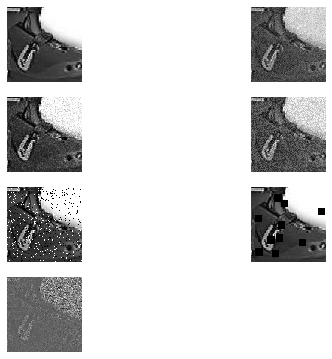

,Noise,MSE,NRMSE,PSNR,SSIM
0,GaussianNoise,389.729464,0.145383,22.223171,0.432649
1,PoissonNoise,249.265600,0.116269,24.164180,0.501477
2,UniformNoise,3330.499634,0.424997,12.905710,0.303178
3,SaltPepperNoise,2388.719900,0.359926,14.349151,0.270539
4,SquareMaskNoise,1346.035100,0.270184,16.840240,0.798937
5,SpeckleNoise,18540.096007,1.002737,5.449684,0.138833


In [4]:
metrics_example(df_noised, noise_class_list)

You can see the score for each type of noise for each metric. We can notice that the type of noise that deteriorates the image the most is SpeckleNoise. We can also see that the Gaussian, Poisson noise is one of the filters that deteriorates the image the least. 

### Create data generator

In [5]:
stats_gen = DataGenerator(df_noised[0:20], batch_size=20)

### Load models

In [6]:
conv_ae_model = load_model(os.path.join(working_dir, "saved_models"), "conv_autoencoder.h5")
dense_ae_model = load_model(os.path.join(working_dir, "saved_models"), "dense_autoencoder.h5")
gan_model = load_model(os.path.join(working_dir, "saved_models"), "gan_generator.h5")

C:\Users\jonas.freiburg\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\keras\layers\core.py:986: UserWarning: debruiteur.models.gan is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### Noise reduction methods

In [7]:
noise_reduction_methods = [('Wiener Filter', lambda img: wiener_filter(img * 255)),
                           ('Laplacian Filter', lambda img: laplacian_filter(img * 255)),
                           ('Gaussian Weighted Filter', lambda img: gaussian_weighted_substract_filter(img * 255)),
                           ('Mean Filter', lambda img: mean_filter(img * 255)),
                           ('Median Filter', lambda img: median_filter(img * 255)),
                           ('Conservative Filter', lambda img: conservative_filter(img * 255)),
                           ('FFT FIlter', lambda img: fft_filter(img * 255)),
                           ('Convolutional Autoencoder', lambda x : conv_ae_model.predict(x.reshape(1, 100, 100, 1)) * 255),
                           ('Dense Autoencoder', lambda x : dense_ae_model.predict(x.reshape(1, 10000)) * 255),
                           ('Generative Adversarial Network', lambda x : gan_model.predict(x.reshape(1, 100, 100, 1)) * 255)]

### Noise reduction methods metrics averaged on all kind of noises

In [8]:
compute_noise_reduction_method_statistics(stats_gen, noise_reduction_methods)

Compute finish for Wiener Filter
Compute finish for Laplacian Filter
Compute finish for Gaussian Weighted Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for FFT FIlter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


,MSE,NRMSE,PSNR,SSIM
Wiener Filter,2533.464191,0.374629,14.536452,0.388520
Laplacian Filter,1691.262737,0.309142,16.271444,0.236364
Gaussian Weighted Filter,3456.772164,0.392595,14.809398,0.550801
Mean Filter,1411.806586,0.278372,17.276572,0.387079
Median Filter,1380.476120,0.269347,17.778047,0.437211
Conservative Filter,1691.760390,0.266128,18.611510,0.643607
FFT FIlter,1243.312011,0.246627,18.713761,0.582328
Convolutional Autoencoder,4069.413346,0.473535,12.667267,0.150623
Dense Autoencoder,5608.869668,0.575515,10.722341,0.008908
Generative Adversarial Network,2660.444941,0.377090,14.714036,0.505423


### Noise reductions methods for each noise type
#### SSIM

In [20]:
df_stat_ssim = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "SSIM")

Compute finish for Wiener Filter
Compute finish for Laplacian Filter
Compute finish for Gaussian Weighted Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for FFT FIlter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Dense Autoencoder,0.007689,0.008667,0.007872,0.008587,0.009185,0.004685
Convolutional Autoencoder,0.173234,0.171232,0.169233,0.131843,0.140218,0.019372
Laplacian Filter,0.204769,0.259617,0.202917,0.214352,0.233808,0.049835
Mean Filter,0.329554,0.427826,0.336327,0.355703,0.388178,0.081917
Median Filter,0.360886,0.459012,0.336101,0.527446,0.445243,0.079826
Wiener Filter,0.368534,0.440512,0.367512,0.359776,0.377383,0.098018
Generative Adversarial Network,0.481292,0.569207,0.467253,0.379536,0.544566,0.116501
FFT FIlter,0.584407,0.666872,0.543454,0.466333,0.645987,0.157051
Gaussian Weighted Filter,0.606089,0.610074,0.503498,0.336859,0.735383,0.200667
Conservative Filter,0.621374,0.710503,0.541227,0.509947,0.825217,0.175202


In [21]:
df_stat_psnr = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "PSNR")

Compute finish for Wiener Filter
Compute finish for Laplacian Filter
Compute finish for Gaussian Weighted Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for FFT FIlter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Dense Autoencoder,10.750108,10.720489,10.755766,10.732249,10.716434,10.455554
Convolutional Autoencoder,13.421041,13.365623,13.356191,12.146056,12.144973,9.882948
Generative Adversarial Network,13.802781,15.655035,14.315765,13.565361,13.479868,9.803152
Wiener Filter,14.943453,16.175111,14.953165,14.838968,13.648557,10.872666
Laplacian Filter,16.025098,17.861982,16.363065,17.336340,15.340798,11.716582
Mean Filter,16.716759,19.320217,17.173071,18.504254,15.391129,11.694964
Median Filter,17.278220,20.086530,17.446296,20.096380,14.661082,11.778376
FFT FIlter,18.698971,22.649208,18.766455,17.754500,17.003207,11.917034
Gaussian Weighted Filter,18.866485,18.860086,17.041849,11.133444,14.125697,11.243438
Conservative Filter,19.293418,24.137352,18.648910,15.816316,16.878537,11.623732


In [22]:
df_stat_mse = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "MSE")

Compute finish for Wiener Filter
Compute finish for Laplacian Filter
Compute finish for Gaussian Weighted Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for FFT FIlter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Conservative Filter,828.866229,252.414967,898.018904,1695.307284,1558.458445,4497.480355
Gaussian Weighted Filter,869.342060,858.467768,1294.445746,4999.062012,2120.866236,4893.268633
FFT FIlter,939.697353,366.299428,873.291006,1088.155364,1445.005089,4354.510313
Median Filter,1237.205342,697.846814,1186.291137,693.813867,2097.020305,4423.554243
Mean Filter,1410.762226,803.954819,1270.196958,954.328617,1902.501192,4417.197684
Laplacian Filter,1653.549250,1117.268675,1532.042733,1252.545635,2115.100805,4501.354327
Wiener Filter,2139.730633,1598.516856,2096.553820,2205.404748,3025.968862,5489.562002
Generative Adversarial Network,2708.557881,1806.792405,2463.751507,2864.087281,3089.754074,7085.522144
Convolutional Autoencoder,3098.835472,3043.289159,3025.942486,4044.720482,4204.951317,7051.122268
Dense Autoencoder,5570.340890,5616.348104,5567.504719,5606.099502,5621.039875,5960.466304


In [23]:
df_stat_rmse = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "NRMSE")

Compute finish for Wiener Filter
Compute finish for Laplacian Filter
Compute finish for Gaussian Weighted Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for FFT FIlter
Compute finish for Convolutional Autoencoder
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Conservative Filter,0.219317,0.121825,0.230807,0.314190,0.302241,0.520268
Gaussian Weighted Filter,0.225156,0.224367,0.277857,0.544820,0.381254,0.536071
FFT FIlter,0.237135,0.146649,0.227463,0.255273,0.285617,0.509704
Median Filter,0.270336,0.201247,0.266838,0.200271,0.368828,0.515351
Mean Filter,0.292625,0.217267,0.275888,0.237888,0.323520,0.511976
Laplacian Filter,0.314437,0.256602,0.302139,0.271620,0.343397,0.515267
Wiener Filter,0.356826,0.304170,0.351156,0.360994,0.404256,0.568922
Generative Adversarial Network,0.405434,0.325998,0.376908,0.406367,0.429345,0.647532
Convolutional Autoencoder,0.426044,0.424947,0.420954,0.490926,0.514341,0.633957
Dense Autoencoder,0.573627,0.575832,0.573473,0.574824,0.575438,0.593505


# Conclusion

As we can observe the conservative filter has the best score on all most all type of noises.  
It may be because the changes in the images are very small so it the denoised image is similar to the original image.  
This is particularly true when the images are not very noised and the performance would be different if the images had more noise.  

The generative adversial neural network reduces the noise quite well, but as the image is generated, the colors are sometimes different which is not the case of other filters.  
When we sum all these small differences pixelwise it is expected to have a high error.  
Even though the results are visually good.  

For each filter the metrics where computed on all kind of noises.  
Usually we should use a specific filter on a particular noise as they perform better on the approriate noise.  

Comparing the neural networks, the generative adversial neural network has the best performances.  
If we had a GPU with more RAM, we could increase the depth of the GAN by putting more convolutional blocks.  
This is also the reason why we reduced the image's size to 100x100 and used grayscale.  
An other improvement would be to implement the style loss in order to keep better texture details and so improve the performance.  

Another point to note is that the structural similarity has been criticized for not being more corelated to the human's perception as the mean squarred error.  
Comparing the images visually is sometimes more valuable than comparing metrics.  

This conclusion shouldn't be used to say that classical filters (gaussian etc) perform better than neural networks in all cases.  